In [17]:
import numpy as np
%matplotlib inline
import pickle
import os


In [18]:
from matplotlib import pyplot as plt


# 激活函数及其导数
def relu(x):
    return np.maximum(0, x)


def relu_derivative(x):
    return np.where(x > 0, 1, 0)


# 均方误差损失函数及其导数
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)


def mean_squared_error_derivative(y_true, y_pred):
    return 2 * (y_pred - y_true) / y_true.size


# MLP类定义
class MLPRegressor:
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, learning_rate, l2_reg=0.01, batch_size=32):
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.l2_reg = l2_reg
        self.batch_size = batch_size
        # Xavier/Glorot初始化
        self.W1 = np.random.randn(input_size, hidden_size1) * np.sqrt(1. / input_size)
        self.W2 = np.random.randn(hidden_size1, hidden_size2) * np.sqrt(1. / hidden_size1)
        self.W3 = np.random.randn(hidden_size2, output_size) * np.sqrt(1. / hidden_size2)
        self.b1 = np.ones((1, hidden_size1)) * 0.01
        self.b2 = np.ones((1, hidden_size2)) * 0.01
        self.b3 = np.ones((1, output_size)) * 0.01

    def forward(self, X):
        # 前向传播
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = relu(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = relu(self.z2)
        self.z3 = np.dot(self.a2, self.W3) + self.b3
        self.a3 = self.z3  # 输出层
        return self.a3

    def backward(self, X, y):
        m = X.shape[0]  # 当前批量的样本数
        y = y.reshape(-1, 1)
        # 计算输出层的梯度
        d_loss_a3 = self.a3 - y

        # 计算第三层的梯度  
        d_loss_W3 = np.dot(self.a2.T, d_loss_a3) / m + self.l2_reg * self.W3
        d_loss_b3 = np.sum(d_loss_a3, axis=0, keepdims=True) / m

        # 计算第二层的梯度
        d_loss_z2 = np.dot(d_loss_a3, self.W3.T) * relu_derivative(self.z2)
        d_loss_W2 = np.dot(self.a1.T, d_loss_z2) / m + self.l2_reg * self.W2
        d_loss_b2 = np.sum(d_loss_z2, axis=0, keepdims=True) / m

        # 计算第一层的梯度
        d_loss_z1 = np.dot(d_loss_z2, self.W2.T) * relu_derivative(self.z1)
        d_loss_W1 = np.dot(X.T, d_loss_z1) / m + self.l2_reg * self.W1
        d_loss_b1 = np.sum(d_loss_z1, axis=0, keepdims=True) / m

        # 更新权重和偏置
        self.W3 -= self.learning_rate * d_loss_W3
        self.b3 -= self.learning_rate * d_loss_b3
        self.W2 -= self.learning_rate * d_loss_W2
        self.b2 -= self.learning_rate * d_loss_b2
        self.W1 -= self.learning_rate * d_loss_W1
        self.b1 -= self.learning_rate * d_loss_b1

    def train(self, X, y, epochs):
        n_samples = X.shape[0]
        losses=[]
        for epoch in range(1, epochs + 1):
            # 随机打乱数据
            indices = np.arange(n_samples)
            np.random.shuffle(indices)
            X = X[indices]
            y = y[indices]

            # 小批量梯度下降
            for i in range(0, n_samples, self.batch_size):
                end = i + self.batch_size
                if end > n_samples:
                    end = n_samples
                X_batch = X[i:end]
                y_batch = y[i:end]
                output = self.forward(X_batch)
                loss = mean_squared_error(y_batch, output)
                losses.append(loss)  # 添加损失值到列表
                self.backward(X_batch, y_batch)

            if epoch % 100 == 0 or epoch == 1 or epoch == epochs:
                output = self.forward(X)
                loss = mean_squared_error(y, output)
                losses.append(loss)  # 添加损失值到列表
                print(f'Epoch {epoch}, Loss: {loss :.4f}')
                
        # 绘制损失曲线
        plt.plot(range(1, epochs + 1), losses, label='Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss Curve')
        plt.legend()
        plt.show()

    def predict(self, X):
        output = self.forward(X)
        return output

    def save_weights(self, file_path):
        weights = {
            'W1': self.W1,
            'b1': self.b1,
            'W2': self.W2,
            'b2': self.b2,
            'W3': self.W3,
            'b3': self.b3
        }
        # 获取文件目录
        directory = os.path.dirname(file_path)
        # 如果目录不存在，则创建目录
        if not os.path.exists(directory):
            os.makedirs(directory)
        # 保存权重
        with open(file_path, 'wb') as file:
            pickle.dump(weights, file)

    def load_weights(self, file_path):
        with open(file_path, 'rb') as file:
            weights = pickle.load(file)
            self.W1 = weights['W1']
            self.b1 = weights['b1']
            self.W2 = weights['W2']
            self.b2 = weights['b2']
            self.W3 = weights['W3']
            self.b3 = weights['b3']

    def r2_score(self, y, output):
        # Calculate the total sum of squares (proportional to the variance of the data)
        total_sum_of_squares = np.sum((y - np.mean(y)) ** 2)

        # Calculate the residual sum of squares
        residual_sum_of_squares = np.sum((y - output) ** 2)

        # Handle edge case where total_sum_of_squares is zero
        if total_sum_of_squares == 0:
            raise ValueError("The total sum of squares is zero, which may indicate that all true values are identical.")

        # Calculate R^2 score
        r2 = 1 - (residual_sum_of_squares / total_sum_of_squares)

        return r2


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing

# 加载加州房价数据集
housing = fetch_california_housing()
X, y = housing.data, housing.target

# 将数据分割成训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# 标准化特征数据
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Epoch 1, Loss: 2.0721
Epoch 100, Loss: 2.2921
Epoch 200, Loss: 2.2876
Epoch 300, Loss: 2.2751
Epoch 400, Loss: 2.2811
Epoch 500, Loss: 2.2781


ValueError: x and y must have same first dimension, but have shapes (500,) and (161506,)

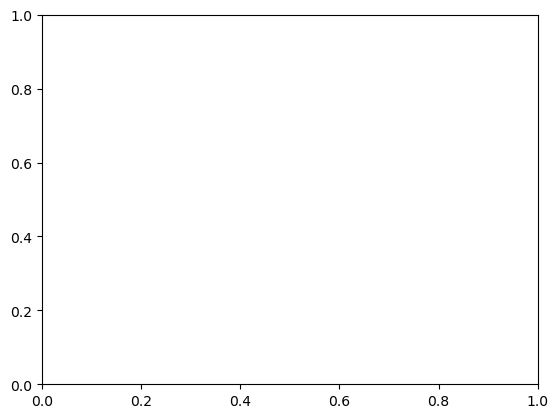

In [20]:
# 创建MLP模型
mlp = MLPRegressor(input_size=X_train_scaled.shape[1], hidden_size1=1024, hidden_size2=512, output_size=1,
                   learning_rate=0.0001)
# 训练MLP模型
mlp.train(X_train_scaled, y_train, epochs=500)
#
# 保存训练后的权重
mlp.save_weights('./weight/mlpregressor_weights.pkl')

In [ ]:
predicted_values = mlp.predict(X_test_scaled)
# 输出结果
print("Predicted values shape:", predicted_values.shape)
print("Sample predicted values:", predicted_values[:5])  # 打印前5个预测值
print("Sample target values:", y_test[:5])  # 打印前5个真实目标值